<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="45%" align="right" border="4">

# Quickstart

This brief first part illustrates---without much explanation---the usage of the DX Analytics library. It models two risk factors, two derivatives instruments and values these in a portfolio context.

In [108]:
import dx
import datetime as dt
import pandas as pd
from pylab import plt
plt.style.use('seaborn')

## Risk Factor Models

The first step is to define a **model for the risk-neutral discounting**.

In [109]:
r = dx.constant_short_rate('r', 0.0271)

We then define a **market environment** containing the major parameter specifications needed,

In [110]:
me_1 = dx.market_environment('me', dt.datetime(2018, 4, 20))

In [111]:
me_1.add_constant('initial_value', 37.44)
  # starting value of simulated processes
me_1.add_constant('volatility',  0.382) ##############
  # volatiltiy factor
me_1.add_constant('final_date', dt.datetime(2018, 5, 18))
  # horizon for simulation
me_1.add_constant('currency', 'USD')
  # currency of instrument
me_1.add_constant('frequency', 'W')
  # frequency for discretization
me_1.add_constant('paths', 10000)
  # number of paths
me_1.add_curve('discount_curve', r)
  # number of paths

Next, the model object for the **first risk factor**, based on the geometric Brownian motion (Black-Scholes-Merton (1973) model).

In [112]:
gbm_1 = dx.geometric_brownian_motion('gbm_1', me_1)

Some paths visualized.

In [113]:
pdf = pd.DataFrame(gbm_1.get_instrument_values(), index=gbm_1.time_grid)

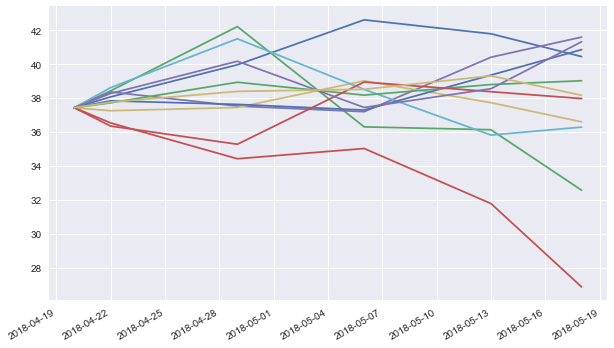

In [114]:
%matplotlib inline
pdf.ix[:, :10].plot(legend=False, figsize=(10, 6))

**Second risk factor** with higher volatility. We overwrite the respective value in the market environment.

In [115]:
me_2 = dx.market_environment('me_2', me_1.pricing_date)
me_2.add_environment(me_1)  # add complete environment
me_2.add_constant('volatility', 0.5)  # overwrite value

In [116]:
gbm_2 = dx.geometric_brownian_motion('gbm_2', me_2)

In [117]:
pdf = pd.DataFrame(gbm_2.get_instrument_values(), index=gbm_2.time_grid)

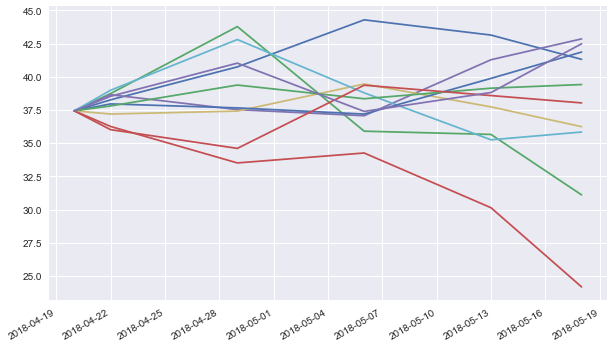

In [118]:
pdf.iloc[:, :10].plot(legend=False, figsize=(10, 6))

## Valuation Models

Based on the risk factors, we can then define derivatives models for valuation. To this end, we need to add at least one (the `maturity`), in general two (`maturity` and `strike`), parameters to the market environments.

In [119]:
me_opt = dx.market_environment('me_opt', me_1.pricing_date)
me_opt.add_environment(me_1)
me_opt.add_constant('maturity', dt.datetime(2018, 5, 18))
me_opt.add_constant('strike', 40.)

The first derivative is an **American put option** on the first risk factor `gbm_1`.

In [120]:
am_put = dx.valuation_mcs_american_single(
            name='am_put',
            underlying=gbm_1,
            mar_env=me_opt,
            payoff_func='np.maximum(strike - instrument_values, 0)')

Let us calculate a **Monte Carlo present value estimate** and estimates for the option **Greeks**.

In [121]:
am_put.present_value()

3.1890000000000001

《ywh添加

In [124]:
am_call = dx.valuation_mcs_american_single(
            name='am_call',
            underlying=gbm_1,
            mar_env=me_opt,
            payoff_func='np.maximum(instrument_values - strike, 0)')

Let us calculate a **Monte Carlo present value estimate** and estimates for the option **Greeks**.

In [125]:
am_call.present_value()

0.69199999999999995

》ywh添加

In [80]:
am_put.delta()

-0.71130000000000004

In [81]:
am_put.gamma()

0.10680000000000001

In [82]:
am_put.vega()

3.5632999999999999

In [83]:
am_put.theta()

-8.5835000000000008

In [84]:
am_put.rho()

-1.9497

The second derivative is a **European call option** on the second risk factor `gbm_2`.

In [85]:
eur_call = dx.valuation_mcs_european_single(
            name='eur_call',
            underlying=gbm_2,
            mar_env=me_opt,
            payoff_func='np.maximum(maturity_value - strike, 0)')

Valuation and Greek estimation for this option.

In [86]:
eur_call.present_value()

1.153224

In [87]:
eur_call.delta()

0.32450000000000001

In [88]:
eur_call.gamma()

0.072800000000000004

In [89]:
eur_call.vega()

3.8203999999999998

In [90]:
eur_call.theta()

-13.4491

In [91]:
eur_call.rho()

0.90600000000000003

## Excursion: SABR Model 

To illustrate how general the approach of DX Analytics is, let us quickly analyze an option based on a SABR stochastic volatility process. In what follows herafter, the SABR model does not play a role.

We need to define different parameters obviously.

In [92]:
me_3 = dx.market_environment('me_3', me_1.pricing_date)
me_3.add_environment(me_1)  # add complete environment

In [93]:
# interest rate like parmeters
me_3.add_constant('initial_value', 0.05)
  # initial value
me_3.add_constant('alpha', 0.1)
  # initial variance
me_3.add_constant('beta', 0.5)
  # exponent
me_3.add_constant('rho', 0.1)
  # correlation factor
me_3.add_constant('vol_vol', 0.5)
  # volatility of volatility/variance

The model object instantiation.

In [94]:
sabr = dx.sabr_stochastic_volatility('sabr', me_3)

The valuation object instantiation.

In [95]:
me_opt.add_constant('strike', me_3.get_constant('initial_value'))

In [96]:
sabr_call = dx.valuation_mcs_european_single(
            name='sabr_call',
            underlying=sabr,
            mar_env=me_opt,
            payoff_func='np.maximum(maturity_value - strike, 0)')

Some statistics --- same syntax/API even if the model is more complex.

In [97]:
sabr_call.present_value(fixed_seed=True)

0.0029550000000000002

In [98]:
sabr_call.delta()

0.57730000000000004

In [99]:
sabr_call.rho()

-0.00020000000000000001

In [100]:
# resetting the option strike
me_opt.add_constant('strike', 110.)

## Options Portfolio

### Modeling

In a portfolio context, we need to add **information about the model class(es)** to be used to the market environments of the risk factors.

In [101]:
me_1.add_constant('model', 'gbm')
me_2.add_constant('model', 'gbm')

To compose a portfolio consisting of our just defined options, we need to define **derivatives positions**. Note that this step is *independent* from the risk factor model and option model definitions. We only use the market environment data and some additional information needed (e.g. payoff functions).

In [102]:
put = dx.derivatives_position(
            name='put',
            quantity=2,
            underlyings=['gbm_1'],
            mar_env=me_opt,
            otype='American single',
            payoff_func='np.maximum(strike - instrument_values, 0)')

In [103]:
call = dx.derivatives_position(
            name='call',
            quantity=3,
            underlyings=['gbm_2'],
            mar_env=me_opt,
            otype='European single',
            payoff_func='np.maximum(maturity_value - strike, 0)')

Let us define the **relevant market** by 2 Python dictionaries, the correlation between the two risk factors and a valuation environment.

In [104]:
risk_factors = {'gbm_1': me_1, 'gbm_2' : me_2}
correlations = [['gbm_1', 'gbm_2', -0.4]]
positions = {'put' : put, 'call' : call}

In [105]:
val_env = dx.market_environment('general', dt.datetime(2016, 1, 1))
val_env.add_constant('frequency', 'W')
val_env.add_constant('paths', 10000)
val_env.add_constant('starting_date', val_env.pricing_date)
val_env.add_constant('final_date', val_env.pricing_date)
val_env.add_curve('discount_curve', r)

These are used to define the **derivatives portfolio**.

In [106]:
port = dx.derivatives_portfolio(
            name='portfolio',  # name 
            positions=positions,  # derivatives positions
            val_env=val_env,  # valuation environment
            risk_factors=risk_factors, # relevant risk factors
            correlations=correlations, # correlation between risk factors
            parallel=False)  # parallel valuation

### Simulation and Valuation

Now, we can get the **position values for the portfolio** via the `get_values` method.

In [107]:
port.get_values()

Maturity date not in time grid of underlying.


UnboundLocalError: local variable 'time_index_start' referenced before assignment

Via the `get_statistics` methods delta and vega values are provided as well.

In [ ]:
port.get_statistics()

Much more complex scenarios are possible with DX Analytics

### Risk Reports

Having modeled the derivatives portfolio, **risk reports** are only two method calls away.

In [ ]:
deltas, benchvalue = port.get_port_risk(Greek='Delta')

In [ ]:
deltas

In [ ]:
deltas.loc(axis=0)[:, 'value'] - benchvalue

In [ ]:
vegas, benchvalue = port.get_port_risk(Greek='Vega', step=0.05)

In [ ]:
vegas

In [ ]:
vegas.loc(axis=0)[:, 'value'] - benchvalue

**Copyright, License & Disclaimer**

&copy; Dr. Yves J. Hilpisch | The Python Quants GmbH

DX Analytics (the "dx library") is licensed under the GNU Affero General Public License
version 3 or later (see [http://www.gnu.org/licenses/](http://www.gnu.org/licenses/)).

DX Analytics comes with no representations
or warranties, to the extent permitted by applicable law.


<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

[http://tpq.io](http://tpq.io) | [team@tpq.io](mailto:team@tpq.io) | [http://twitter.com/dyjh](http://twitter.com/dyjh)

**Quant Platform** |
[http://quant-platform.com](http://quant-platform.com)

**Derivatives Analytics with Python (Wiley Finance)** |
[http://derivatives-analytics-with-python.com](http://derivatives-analytics-with-python.com)

**Python for Finance (O'Reilly)** |
[http://python-for-finance.com](http://python-for-finance.com)